### Question: Can we predict which author wrote a specfic piece of text by using the text? After creating the model, where does the model perform well and where does it suffer? Does it frequently misclassify authors that are similar?

### Approach: We read in the data, created a bag of words matrix, and built a naive-bayes model. We evaluated the accuracy of the model on the test set and created a large confusion matrix. After identifiying the most common errors in our confusion matrix we will evaluate the similarity between these authors using the t-SNE visualization. Our hypothesis is that these author's writings will be quite similar and that is one reason that misclassifcation is happening.

In [37]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.svm import SVC
import xgboost as xgb

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    if '.DS_Store' in authors:
        authors.remove('.DS_Store')
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            if file_name != '.DS_Store':
                file_path = os.path.join(author_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                    labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory('./datafile/ReutersC50/C50train')
test_texts, test_labels = read_data_from_directory('./datafile/ReutersC50/C50test')


[nltk_data] Downloading package punkt to /Users/carson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
word_tokenize(train_texts[0])

['Drugstore',
 'giant',
 'Revco',
 'D.S',
 '.',
 'Inc.',
 'said',
 'Monday',
 'it',
 'agreed',
 'to',
 'buy',
 'regional',
 'chain',
 'Big',
 'B',
 'Inc.',
 'in',
 'a',
 'sweetened',
 'takeover',
 'valued',
 'at',
 '$',
 '380',
 'million',
 '.',
 'The',
 'transaction',
 'calls',
 'for',
 'Twinsburg',
 ',',
 'Ohio-based',
 'Revco',
 'to',
 'buy',
 'all',
 'outstanding',
 'shares',
 'of',
 'Big',
 'B',
 'common',
 'stock',
 'for',
 '$',
 '17.25',
 'per',
 'share',
 ',',
 'up',
 'from',
 'Revco',
 "'s",
 'unsolicited',
 'offer',
 'of',
 '$',
 '15',
 'per',
 'share',
 ',',
 'which',
 'Big',
 'B',
 'rejected',
 'last',
 'month',
 '.',
 '``',
 'We',
 'are',
 'very',
 'excited',
 'about',
 'the',
 'combination',
 'of',
 'Revco',
 'and',
 'Big',
 'B.',
 'I',
 'am',
 'pleased',
 'we',
 'were',
 'able',
 'to',
 'bring',
 'this',
 'process',
 'to',
 'a',
 'fast',
 'and',
 'successful',
 'conclusion',
 ',',
 "''",
 'said',
 'Dwayne',
 'Hoven',
 ',',
 'president',
 'and',
 'chief',
 'executive',
 '

In [17]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

def preprocess_text2(text):
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Basic Statistics
print(f"Total number of training documents: {len(train_texts)}")
print(f"Total number of test documents: {len(test_texts)}")

train_doc_lengths = [len(preprocess_text(text)) for text in train_texts]
test_doc_lengths = [len(preprocess_text(text)) for text in test_texts]

print(f"\nAverage document length in training set: {np.mean(train_doc_lengths)} words")
print(f"Minimum document length in training set: {np.min(train_doc_lengths)} words")
print(f"Maximum document length in training set: {np.max(train_doc_lengths)} words")
print(f"\nAverage document length in test set: {np.mean(test_doc_lengths)} words")
print(f"Minimum document length in test set: {np.min(test_doc_lengths)} words")
print(f"Maximum document length in test set: {np.max(test_doc_lengths)} words")


Total number of training documents: 2500
Total number of test documents: 2500

Average document length in training set: 328.4308 words
Minimum document length in training set: 33 words
Maximum document length in training set: 957 words

Average document length in test set: 333.2564 words
Minimum document length in test set: 42 words
Maximum document length in test set: 934 words



Most common words across the training set:
said: 19856
's: 14872
'': 13882
``: 13712
year: 6146
compani: 5651
would: 5237
percent: 5211
million: 4942
market: 4629


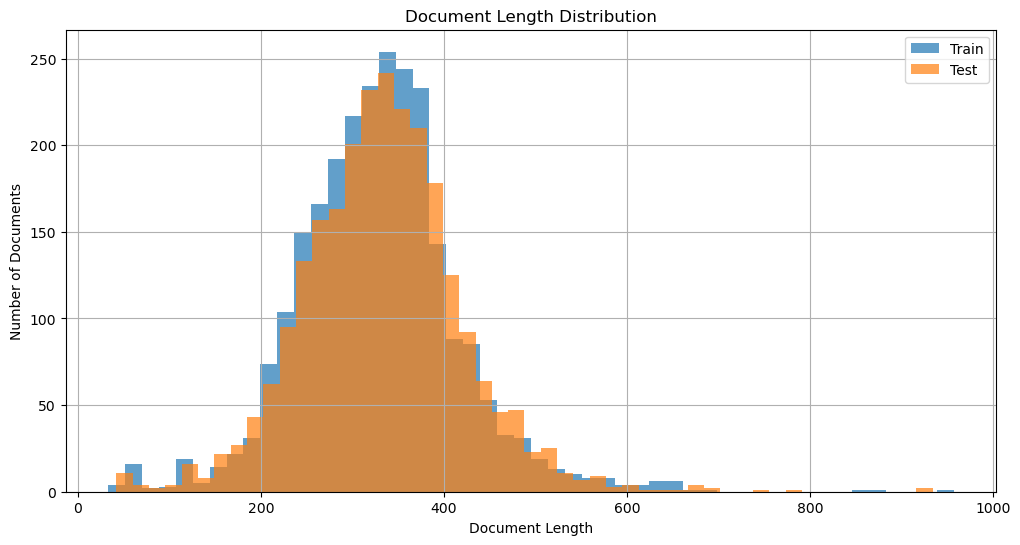

In [5]:
# Term Frequencies
all_tokens = [token for text in train_texts for token in preprocess_text(text)]
common_tokens = Counter(all_tokens).most_common(10)
print("\nMost common words across the training set:")
for token, freq in common_tokens:
    print(f"{token}: {freq}")

# Document Length Distribution
plt.figure(figsize=(12, 6))
plt.hist(train_doc_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_doc_lengths, bins=50, alpha=0.7, label='Test')
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# The CountVectorizer will now use my custom tokenizer/preprocesser
vectorizer = CountVectorizer(tokenizer=preprocess_text, stop_words='english', max_features=2500)
train_dtm = vectorizer.fit_transform(train_texts)
test_dtm = vectorizer.transform(test_texts)

/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 

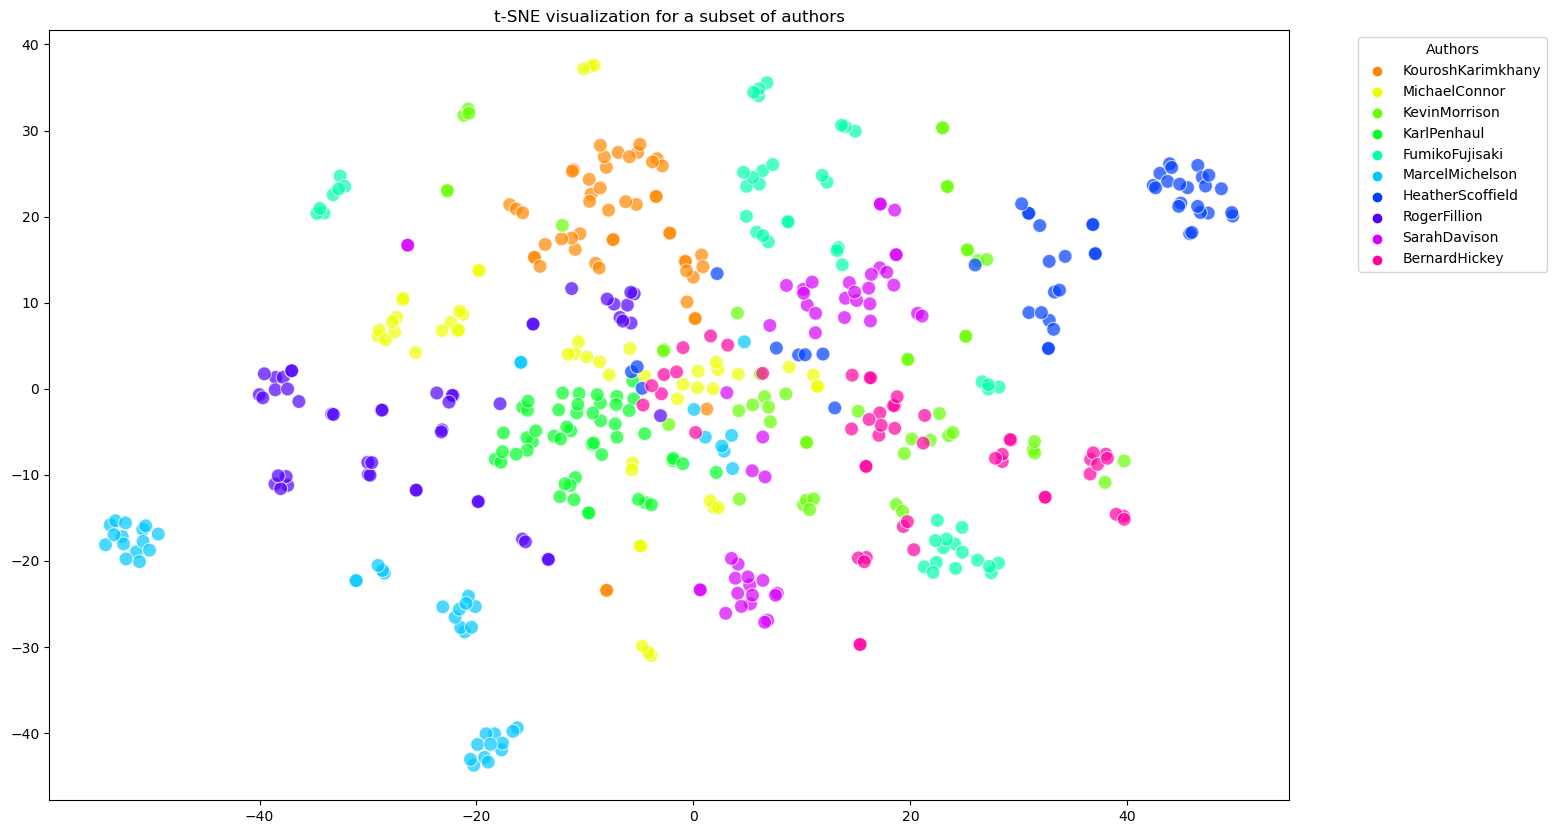

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import random

# 1. Choose a subset of 10 authors
unique_authors = list(set(train_labels))
selected_authors = random.sample(unique_authors, 10)

# 2. Filter the training data
filtered_indices = [i for i, label in enumerate(train_labels) if label in selected_authors]
filtered_texts = [train_texts[i] for i in filtered_indices]
filtered_labels = [train_labels[i] for i in filtered_indices]
filtered_dtm = train_dtm[filtered_indices]

# 3. PCA and t-SNE
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(filtered_dtm.toarray())  # Convert sparse matrix to dense matrix
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

# 4. Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=filtered_labels,
    palette=sns.color_palette("hsv", len(selected_authors)),
    alpha=0.7,
    s=100
)
plt.title('t-SNE visualization for a subset of authors')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Results: Based on the bag of words matrix we created, we built a Naive Bayes classifer to predict which author wrote a new piece of text. 

A naive bayes model is a common and good choice for this type of prediction because of its efficiency and low data requirements. We attempted to run a Word2Vec model but had it only had a 14% accuracy. This is likely due to the low amount of data we have. 

In [35]:
# Create and train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(train_dtm, train_labels)

# Make predictions on the test data
predictions = classifier.predict(test_dtm)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6472


After data preprocessing we achieved a 64.72% accuracy, which is very good compared to the baseline classifier which would be only 2% (1/50). We will now create a very large confusion matrix to see where misclassifications typically happened.

In [62]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(test_labels, predictions)

In [63]:
labels = np.unique(np.concatenate((test_labels, predictions)))

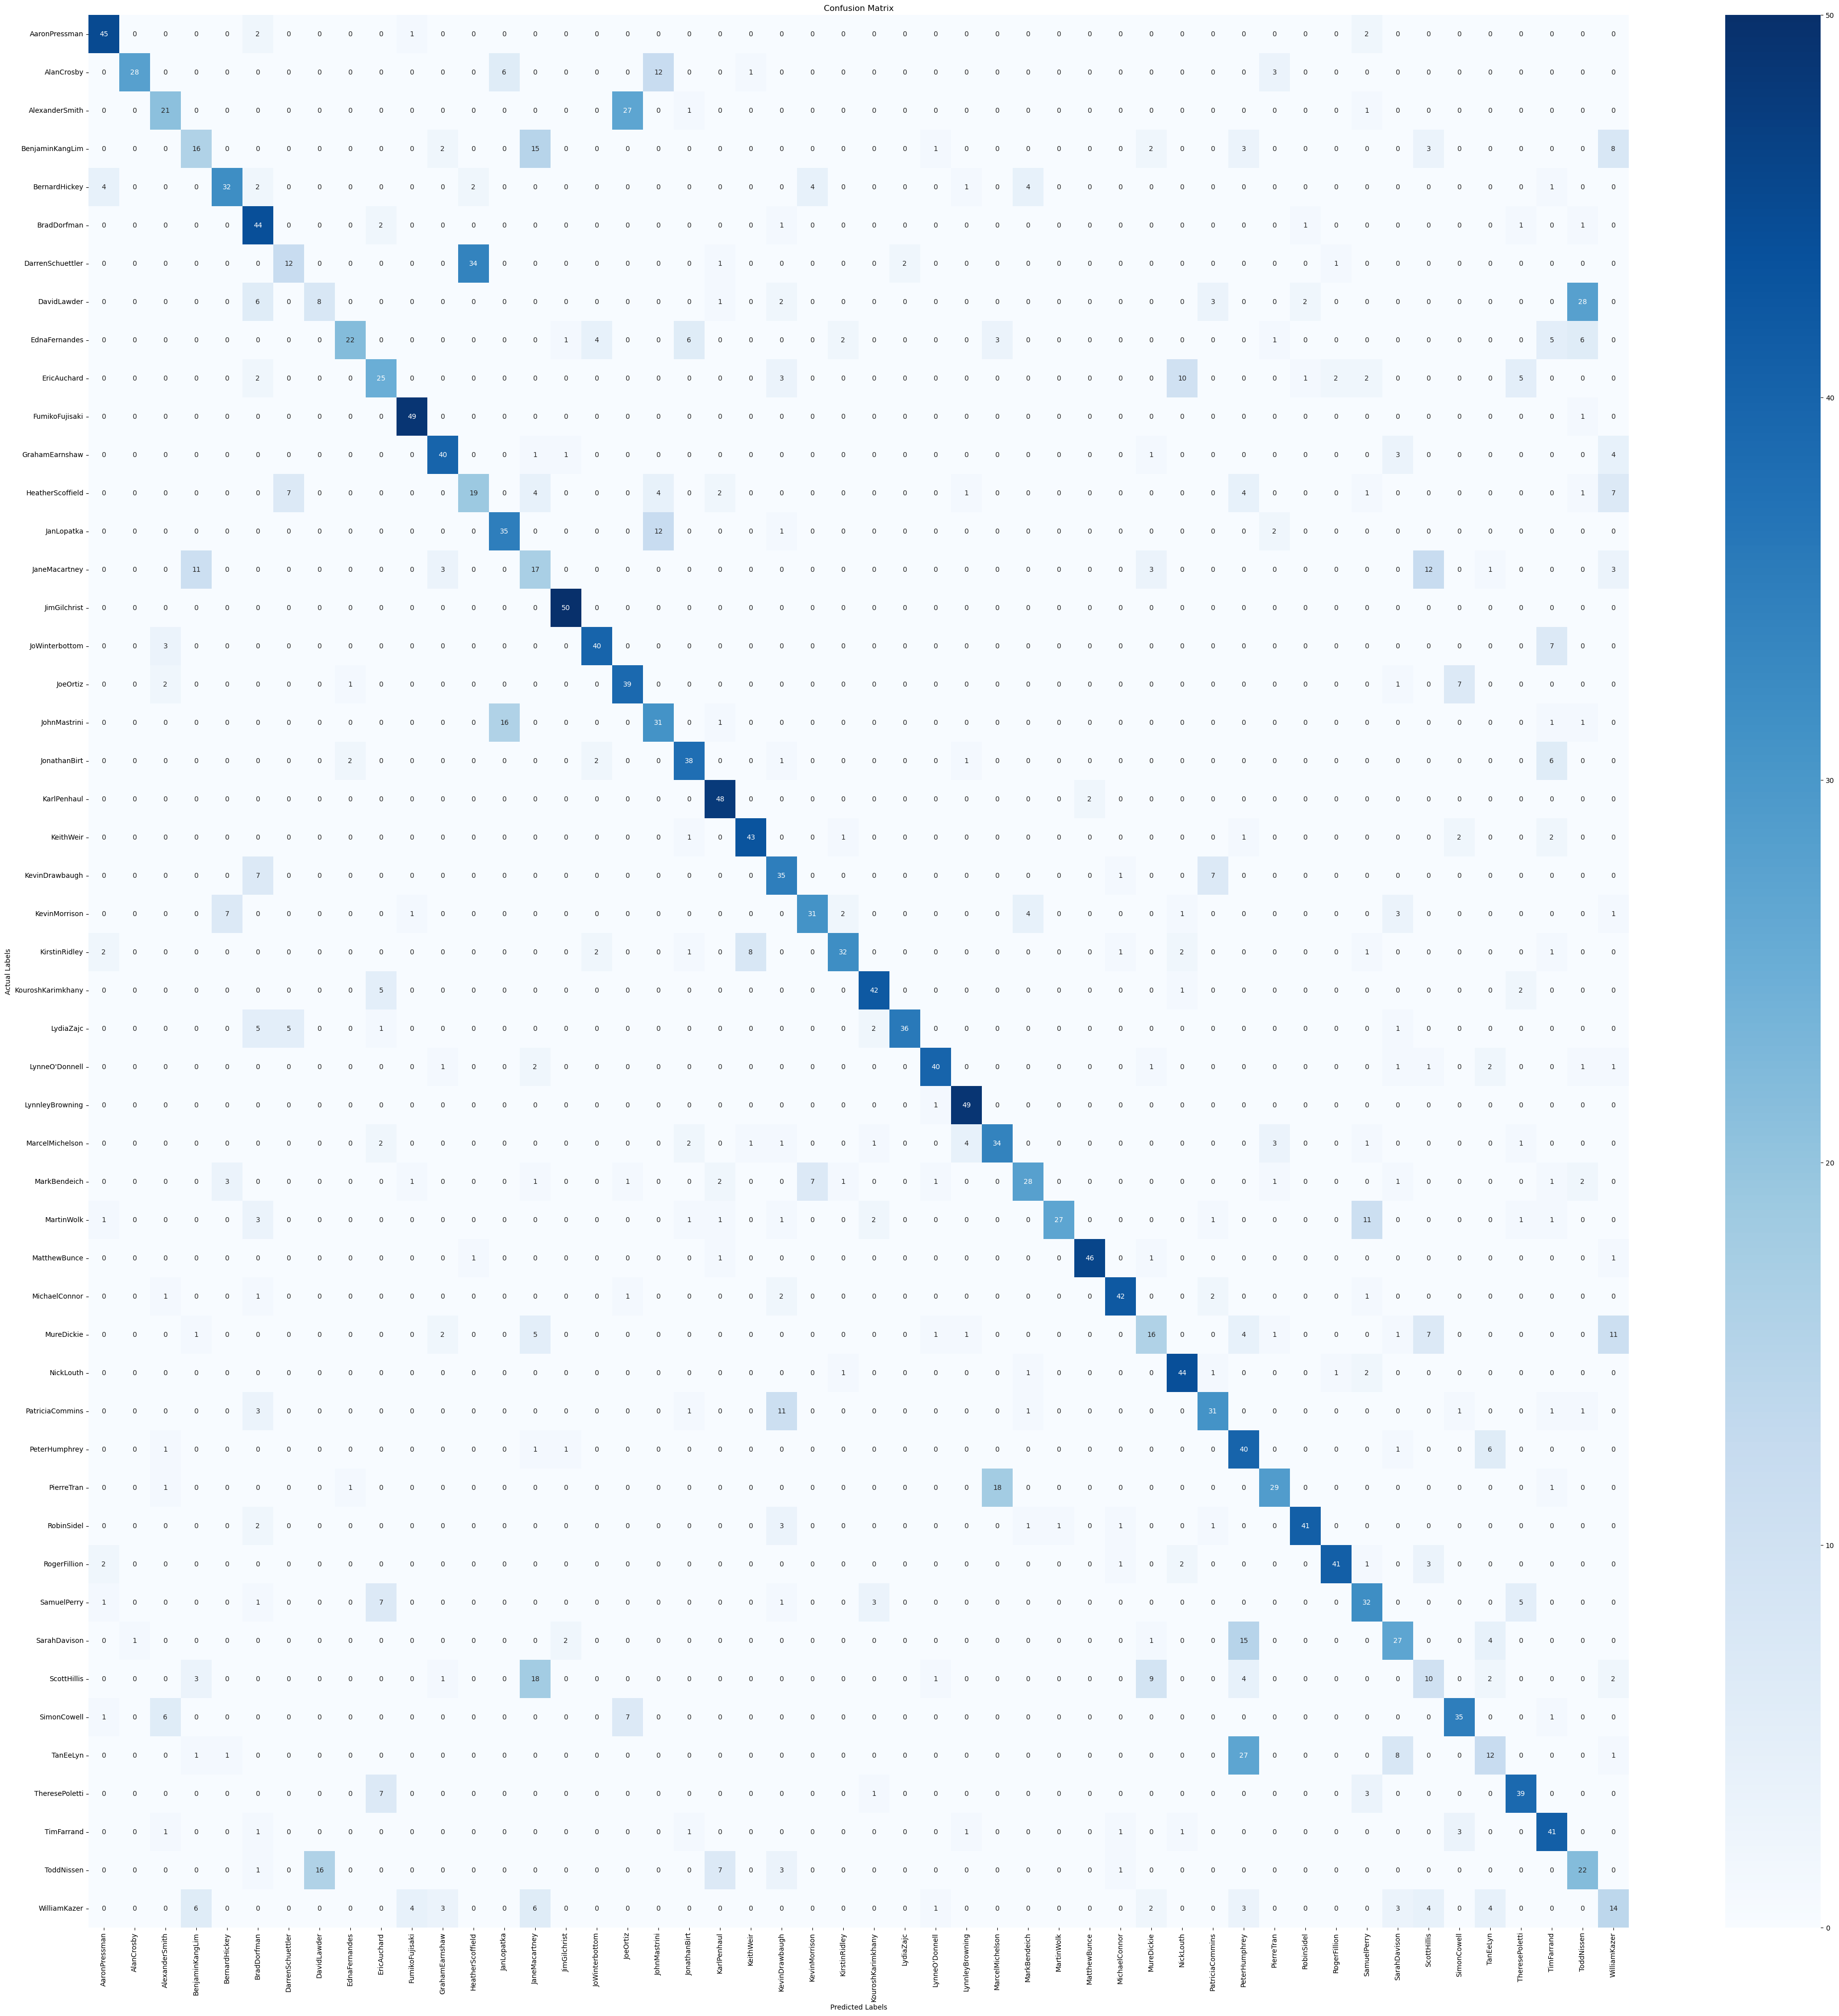

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a heatmap for visualization
plt.figure(figsize=(50, 50))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


The overall accuracy of the model is quite impressive because of the high number of classes that we have. Some of the larger mistakes are 34 of Darren Schuettler's text were predicted to be written by Heather Scoffield. 28 of David Lawder's text were classifed as Todd Nissen. 27 of Tan EeLyn's text were classied as Peter Humphrey's work. 27 of Alexander Smith's work to be Joe Ortiz. Lastly, 18 of Scott Hillis's works were classified as Jane Macartney's. These are quite signifcant errors as more of the text files are being classified to the incorrect author than to the correct author

Based on these extreme misclassifications, we will rerun the t-SNE to see if their works are classified similarly on both the test and training set. 

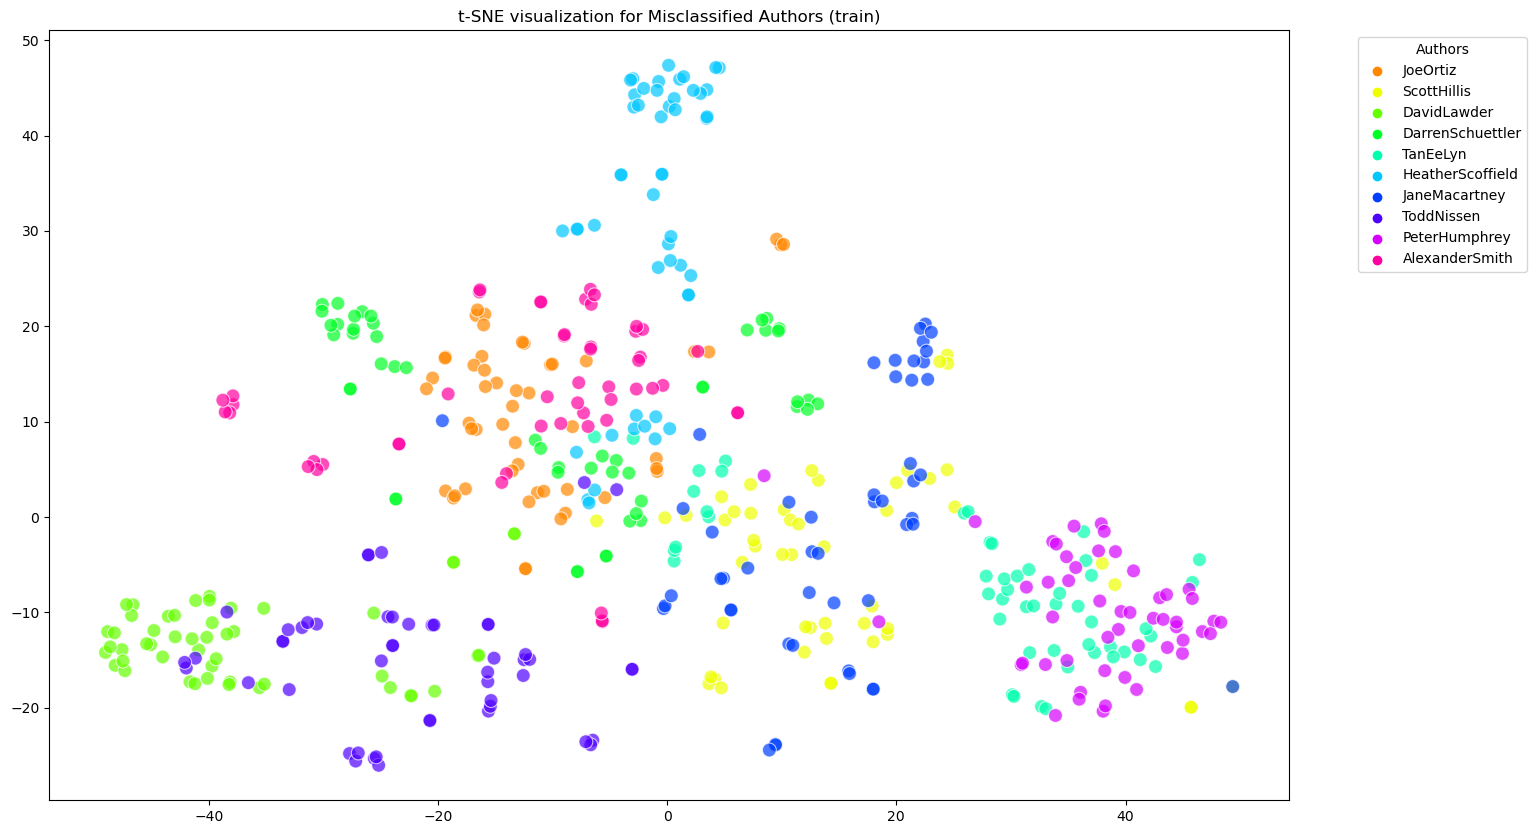

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import random

# 1. Choose a subset of 10 authors
unique_authors = list(set(train_labels))
selected_authors = ['DarrenSchuettler', 'HeatherScoffield', 'DavidLawder', 'ToddNissen', 'TanEeLyn', 'PeterHumphrey', 'AlexanderSmith', 'JoeOrtiz', 'ScottHillis', 'JaneMacartney']

# 2. Filter the training data
filtered_indices = [i for i, label in enumerate(train_labels) if label in selected_authors]
filtered_texts = [train_texts[i] for i in filtered_indices]
filtered_labels = [train_labels[i] for i in filtered_indices]
filtered_dtm = train_dtm[filtered_indices]

# 3. PCA and t-SNE
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(filtered_dtm.toarray())  # Convert sparse matrix to dense matrix
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

# 4. Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=filtered_labels,
    palette=sns.color_palette("hsv", len(selected_authors)),
    alpha=0.7,
    s=100
)
plt.title('t-SNE visualization for Misclassified Authors (train)')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



For the most part this graph makes a lot of sense. In the training t-SNE the writings of Peter Humphrey and Tan EeLyn are very similar. Similarly, Scott Hillis and Jane Macartney, Todd Nissen and David Lawder, and Alexander Smith and Joe Ortiz have similar distributions. Heather Scoffield and Darren Schuettler's relationship isn't as clear, as their writings do not follow an obvious pattern. 

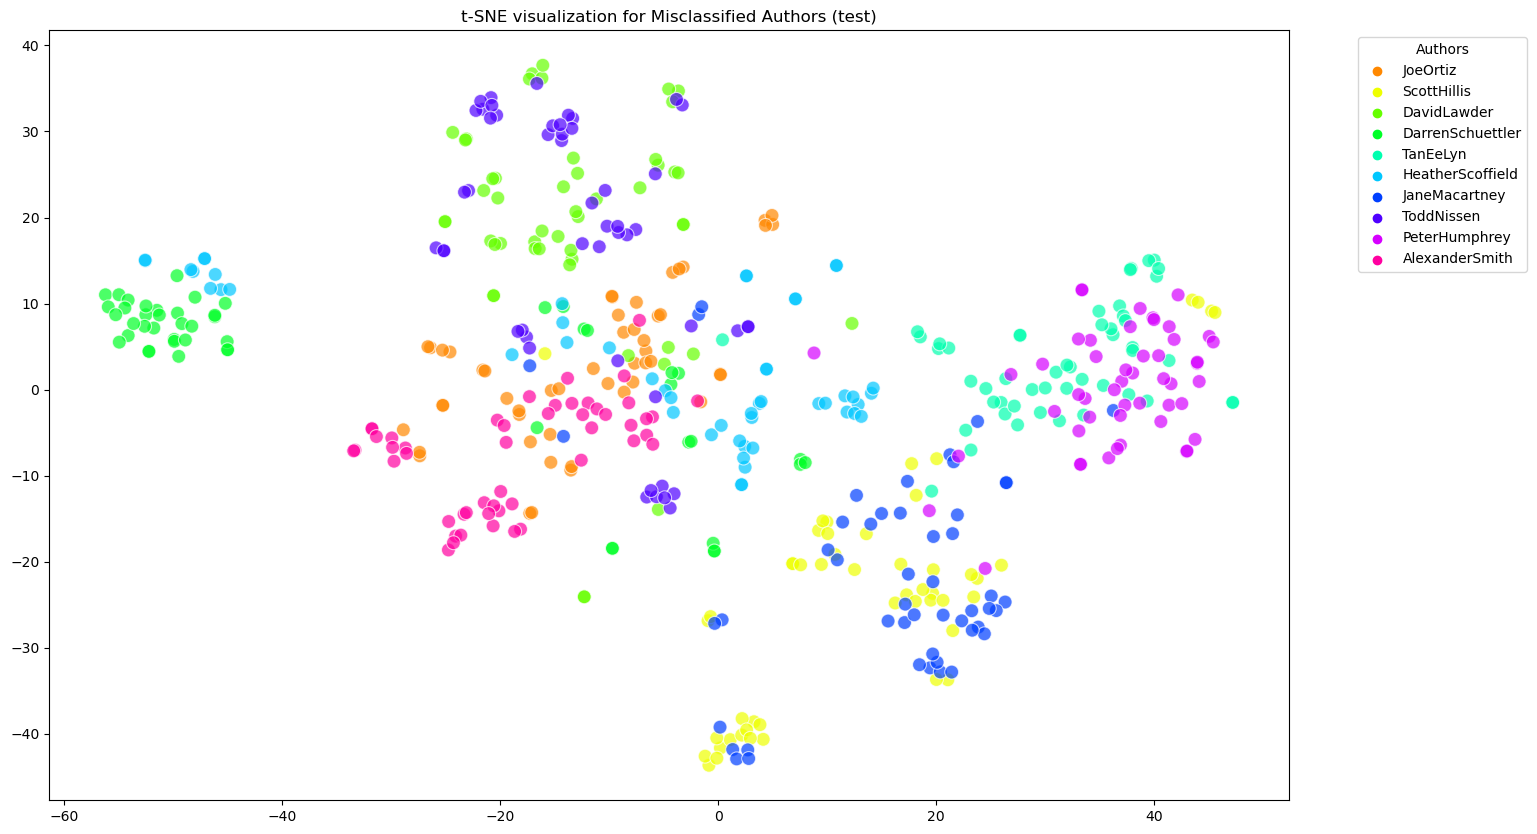

In [87]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import random

# 1. Choose a subset of 10 authors
unique_authors = list(set(test_labels))
selected_authors = ['DarrenSchuettler', 'HeatherScoffield', 'DavidLawder', 'ToddNissen', 'TanEeLyn', 'PeterHumphrey', 'AlexanderSmith', 'JoeOrtiz', 'ScottHillis', 'JaneMacartney']

# 2. Filter the training data
filtered_indices = [i for i, label in enumerate(test_labels) if label in selected_authors]
filtered_texts = [test_texts[i] for i in filtered_indices]
filtered_labels = [test_labels[i] for i in filtered_indices]
filtered_dtm = test_dtm[filtered_indices]

# 3. PCA and t-SNE
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(filtered_dtm.toarray())  # Convert sparse matrix to dense matrix
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

# 4. Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=filtered_labels,
    palette=sns.color_palette("hsv", len(selected_authors)),
    alpha=0.7,
    s=100
)
plt.title('t-SNE visualization for Misclassified Authors (test)')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



The test t-SNE visualization shows similar relations from Scott Hillis and Jane Macartney, Peter Humphrey and Tan EeLyn, David Lawder and Todd Nissen, and Joe Ortiz and Alexander Smith. Even for Darren Schuettler and Heather Scoffield there is a clearer relationship as their clusters are quite close together. It makes a lot of sense that authors who had their writings misclassifed are similar to one another from a t-SNE perspective. 

In conclusion, it is possible to predict the author of text using machine learning based on writing content and style. We were able to create a model that was 32x more accurate than a baseline classifier by using a very simple naive bayes model. Additionally, it seems that the misclassifications are from authors that are quite similar to one another. The t-SNE visualizations illustrated the similarity in the misclassified authors' works and provides a simple explaination to why they might be incorrect. 